<a href="https://colab.research.google.com/github/Siuuuuuu0/ML-DL/blob/main/CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
import torch
import pandas as pd
from torch import nn
import random

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [178]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(52)

In [179]:
train_data  = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform=None
)

test_data  = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor(),
    target_transform=None
)


In [180]:
class_names = train_data.classes

In [181]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [182]:
img, label = train_data[0]

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

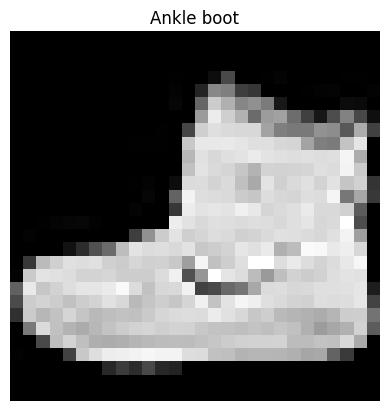

In [183]:
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

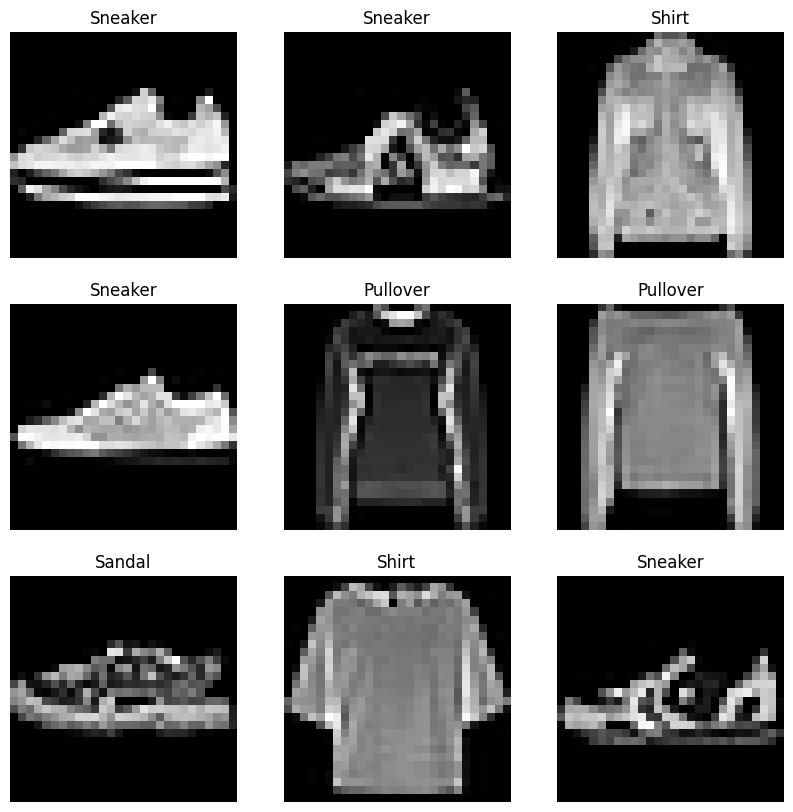

In [184]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i in range(3):
  for j in range(3):
    idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[idx]
    axes[i, j].imshow(img.squeeze(), cmap="gray")
    axes[i, j].set_title(class_names[label])
    axes[i, j].axis(False)

In [185]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [186]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [187]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

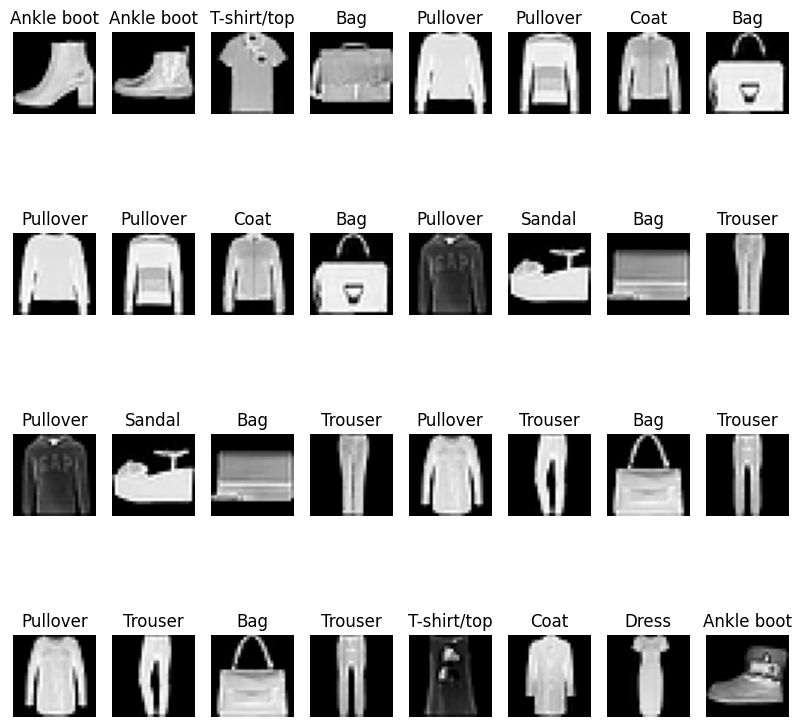

In [188]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(10,10))

for i in range(4):
  for j in range(8):
    idx = i*4+j
    img, label = train_features_batch[idx], train_labels_batch[idx]
    axes[i, j].imshow(img.squeeze(), cmap="gray")
    axes[i, j].set_title(class_names[label])
    axes[i, j].axis(False)

In [189]:
class FashionModel(nn.Module):
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape: int
  ):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.Linear(in_features=hidden_units, out_features=output_shape)
  )

  def forward(self, x):
    return self.layer_stack(x)

In [190]:
model = FashionModel(
    input_shape = 28*28,
    hidden_units = 16,
    output_shape = len(class_names)
).to(device)

In [191]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [192]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [193]:
def print_train_time(
    start,
    end,
    device
):
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [194]:
train_time_start_cpu = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}")
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)
    model.train()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%400 == 0:
      print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")
  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)

      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print(f"Train loss: {train_loss:.2f}, Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}")

train_time_end_cpu = timer()
train_time_model_base = print_train_time(start=train_time_start_cpu, end=train_time_end_cpu, device=next(model.parameters()).device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.59, Test loss: 0.51, Test acc: 81.75
Epoch 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.48, Test loss: 0.49, Test acc: 82.42
Epoch 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.45, Test loss: 0.60, Test acc: 80.72
Epoch 3
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.44, Test loss: 0.49, Test acc: 83.00
Epoch 4
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss: 0.44, Test los

In [195]:
def eval_model(model, data_loader, loss_fn, accuracy_fn, device=device):
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__, "model_loss":loss.item(), "model_acc":acc}

model_results = eval_model(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
model_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionModel',
 'model_loss': 0.4577368497848511,
 'model_acc': 83.60623003194888}

In [196]:
!nvidia-smi

Thu Jan 15 12:19:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             32W /   70W |     188MiB /  15360MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [197]:
class FashionModelNonLinear(FashionModel):
  def __init__(
      self,
      input_shape: int,
      hidden_units: int,
      output_shape: int
  ):
    super().__init__(input_shape, hidden_units, output_shape)
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
      nn.ReLU()
  )

In [198]:
model_non_linear = FashionModelNonLinear(
    input_shape = 28*28,
    hidden_units = 16,
    output_shape = len(class_names)
).to(device)
model_non_linear

FashionModelNonLinear(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [199]:
optimizer = torch.optim.SGD(params=model_non_linear.parameters(), lr=0.1)

In [200]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device=device):
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.2f}, Train acc: {train_acc:.2f}%")

In [201]:
def test_step(model, data_loader, loss_fn, accuracy_fn, device=device):
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)

      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}%")

In [202]:
train_time_start_cpu = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}")

  train_step(model_non_linear, train_dataloader, loss_fn, optimizer, accuracy_fn)

  test_step(model_non_linear, test_dataloader, loss_fn, accuracy_fn)

train_time_end_cpu = timer()
train_time_model_nn = print_train_time(start=train_time_start_cpu, end=train_time_end_cpu, device=next(model_non_linear.parameters()).device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
Train loss: 1.02, Train acc: 68.84%
Test loss: 0.90, Test acc: 73.97%
Epoch 1
Train loss: 0.80, Train acc: 75.54%
Test loss: 0.69, Test acc: 78.43%
Epoch 2
Train loss: 0.64, Train acc: 80.97%
Test loss: 0.68, Test acc: 76.94%
Epoch 3
Train loss: 0.50, Train acc: 84.06%
Test loss: 0.44, Test acc: 84.58%
Epoch 4
Train loss: 0.41, Train acc: 85.52%
Test loss: 0.48, Test acc: 83.22%
Train time on cuda:0 : 46.976 seconds


In [203]:
model_results_nn = eval_model(model=model_non_linear, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model_results_nn

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionModelNonLinear',
 'model_loss': 0.4754657745361328,
 'model_acc': 83.21685303514377}

In [204]:
class FashionModelCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    return x


In [205]:
model_cnn = FashionModelCNN(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model_cnn

FashionModelCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [206]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_cnn.parameters(), lr=0.1)

In [207]:
train_time_start_cpu = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}")

  train_step(model_cnn, train_dataloader, loss_fn, optimizer, accuracy_fn)

  test_step(model_cnn, test_dataloader, loss_fn, accuracy_fn)

train_time_end_cpu = timer()
train_time_model_cnn = print_train_time(start=train_time_start_cpu, end=train_time_end_cpu, device=next(model_cnn.parameters()).device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
Train loss: 0.60, Train acc: 78.41%
Test loss: 0.42, Test acc: 84.57%
Epoch 1
Train loss: 0.39, Train acc: 85.97%
Test loss: 0.36, Test acc: 86.36%
Epoch 2
Train loss: 0.34, Train acc: 87.68%
Test loss: 0.34, Test acc: 87.42%
Epoch 3
Train loss: 0.32, Train acc: 88.47%
Test loss: 0.32, Test acc: 88.51%
Epoch 4
Train loss: 0.30, Train acc: 89.10%
Test loss: 0.33, Test acc: 88.20%
Train time on cuda:0 : 55.690 seconds


In [208]:
model_cnn_results = eval_model(
    model=model_cnn,
    data_loader = test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn = accuracy_fn,
    device = device
)

model_cnn_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionModelCNN',
 'model_loss': 0.3342546820640564,
 'model_acc': 88.19888178913737}

In [209]:
compare_results = pd.DataFrame(
    [model_results,
    model_results_nn,
    model_cnn_results]
)

compare_results

,model_name,model_loss,model_acc
0,FashionModel,0.457737,83.606230
1,FashionModelNonLinear,0.475466,83.216853
2,FashionModelCNN,0.334255,88.198882


In [210]:
compare_results["training_time"]=[
    train_time_model_base,
    train_time_model_nn,
    train_time_model_cnn
]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionModel,0.457737,83.606230,45.732733
1,FashionModelNonLinear,0.475466,83.216853,46.975653
2,FashionModelCNN,0.334255,88.198882,55.689794


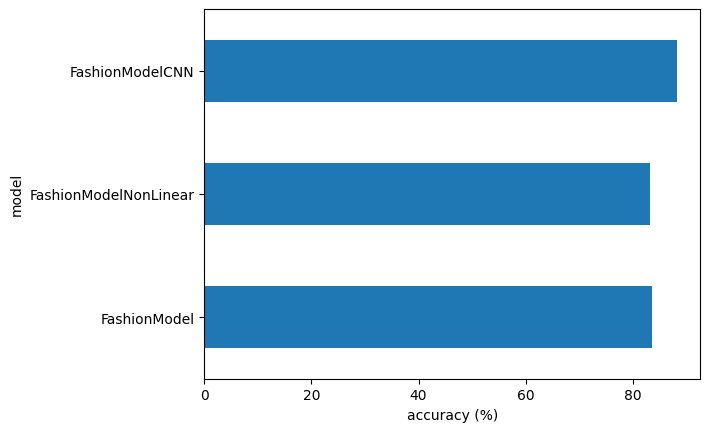

In [211]:
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")
plt.show()

In [212]:
def make_pred(model,
              data,
              device = device):
  pred_probs = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [213]:
test_samples = []

test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [214]:
pred_probs = make_pred(model=model_cnn,
                       data=test_samples)

pred_classes = pred_probs.argmax(dim=1)

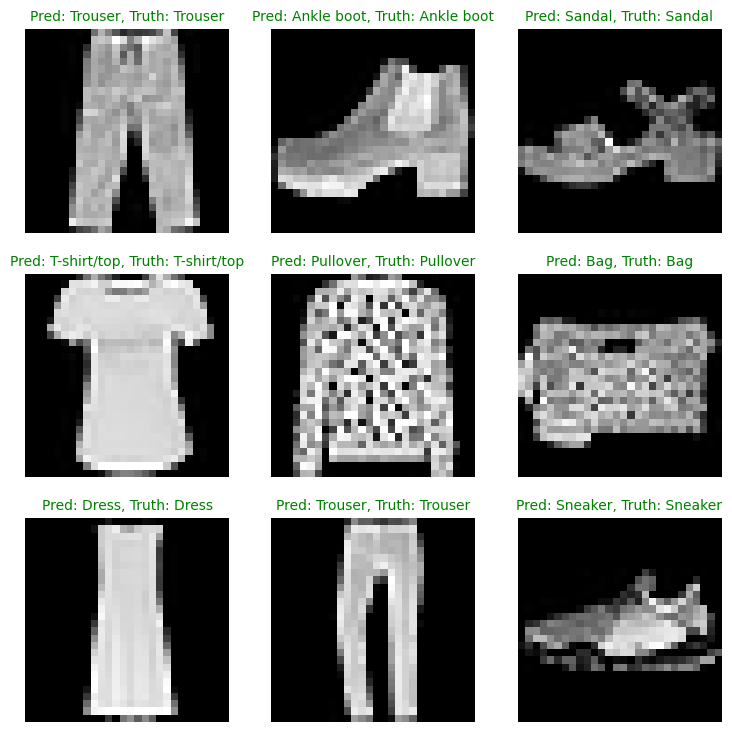

In [215]:
plt.figure(figsize=(9, 9))

nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label}, Truth: {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)

In [216]:
y_preds = []
model_cnn.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_cnn(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 3])

In [217]:
import mlxtend

In [218]:
mlxtend.__version__

'0.23.4'

In [219]:
!pip install torchmetrics

In [220]:
import torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_names), task="multiclass")

confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

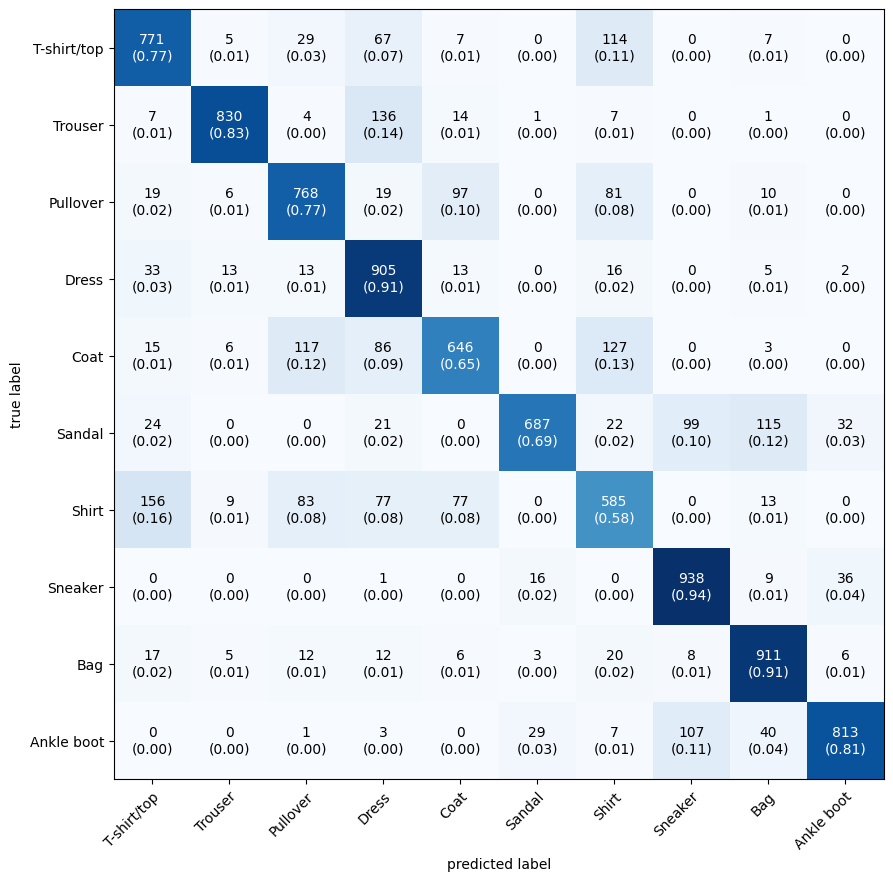

In [221]:
fig, axes = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    figsize = (10, 10),
    class_names = class_names,
    show_normed = True
)

In [222]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=model_cnn.state_dict(),
           f=MODEL_SAVE_PATH)

In [223]:
torch.manual_seed(52)

loaded_model_cnn = FashionModelCNN(input_shape=1,
                                   hidden_units=10,
                                   output_shape=len(class_names))

loaded_model_cnn.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_cnn.to(device)

FashionModelCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [224]:
model_cnn_results

{'model_name': 'FashionModelCNN',
 'model_loss': 0.3342546820640564,
 'model_acc': 88.19888178913737}

In [225]:
torch.manual_seed(52)

loaded_model_cnn_results = eval_model(
    model=loaded_model_cnn,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_cnn_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionModelCNN',
 'model_loss': 0.3342546820640564,
 'model_acc': 88.19888178913737}

In [226]:
torch.isclose(torch.tensor(model_cnn_results["model_loss"]),
              torch.tensor(loaded_model_cnn_results["model_loss"]),
              atol=1e-02)

tensor(True)